In [40]:
import sqlalchemy
import pandas as pd

import mplfinance as mpf
from remy_workflow.patterns import patterns

import ipywidgets as widgets
import talib


In [15]:
db_connection_string = 'sqlite:///./Resources/products.db'
engine  = sqlalchemy.create_engine(db_connection_string)

inspector = sqlalchemy.inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

['MSFT_1_Day_Candles', 'MSFT_1_Min_Candles', 'MSFT_Info', 'Stock_Company_Info']


In [16]:
# Update table names by looking at the list created above
# MSFT was used to create the example, replace it with the symbol you used
daily_df = pd.read_sql_table(
    'MSFT_1_Day_Candles', 
    con=engine, 
    index_col='Datetime',
    )
minutely_df = pd.read_sql_table('MSFT_1_Min_Candles', con=engine, index_col='Datetime')

In [17]:
# print(daily_df.tail())

In [18]:
# print(minutely_df.tail())

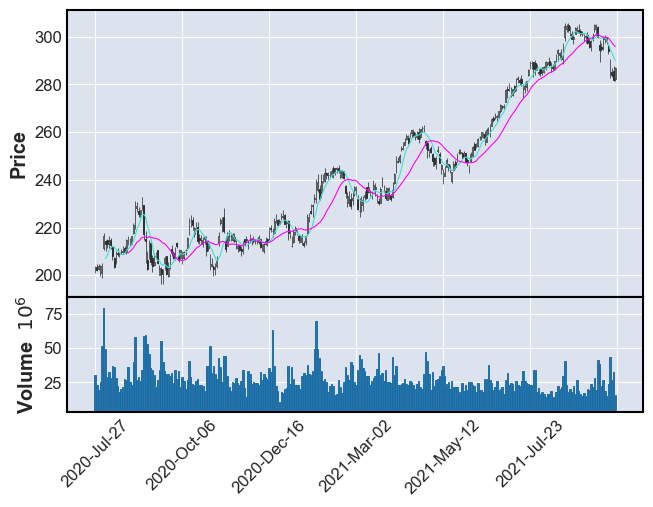

In [19]:
daily_slice = daily_df.iloc[-300:]
daily_candle_plot, ax = mpf.plot(
    # portfolio_list[0], 
    daily_slice, 
    type='candle', 
    volume=True, 
    returnfig=True,
    mav=(7,20),
    )


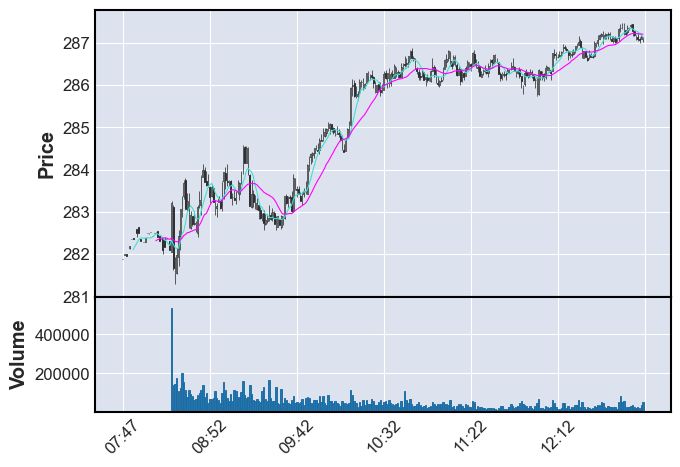

In [20]:
minutely_slice = minutely_df.iloc[-300:]
minutely_candle_plot, ax = mpf.plot(
    # portfolio_list[0], 
    minutely_slice, 
    type='candle', 
    volume=True, 
    returnfig=True,
    mav=(7,20),
    )


In [28]:
pattern_list = []
pattern_df = pd.DataFrame(list(patterns.items()), columns=['Index', 'Pattern'])
pattern_df = pattern_df.set_index('Index')
# print(pattern_df)
for pattern, p_name in patterns.items():
    pattern_list.append(pattern)

                                               Pattern
Index                                                 
CDL2CROWS                                    Two Crows
CDL3BLACKCROWS                       Three Black Crows
CDL3INSIDE                        Three Inside Up/Down
CDL3LINESTRIKE                       Three-Line Strike
CDL3OUTSIDE                      Three Outside Up/Down
...                                                ...
CDLTHRUSTING                         Thrusting Pattern
CDLTRISTAR                             Tristar Pattern
CDLUNIQUE3RIVER                         Unique 3 River
CDLUPSIDEGAP2CROWS                Upside Gap Two Crows
CDLXSIDEGAP3METHODS  Upside/Downside Gap Three Methods

[61 rows x 1 columns]


In [29]:
# vals = ['km', 'm', 'cm','mm']
sel = widgets.SelectMultiple(
        options=pattern_df['Pattern'],
        # options=pattern_list,
        # value=['m'],
        rows=min(25, len(pattern_list)),
        # column_stack=True,
        description='Unit:'
    )
display(sel)


SelectMultiple(description='Unit:', options=('Two Crows', 'Three Black Crows', 'Three Inside Up/Down', 'Three-…

In [45]:
df = daily_df
sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index)
for pattern in sel_pattern_list:
    pattern_function = getattr(talib, pattern)
    try:
        result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
        df[pattern] = result
    except Exception as e:
        print(f"{type(e)} Exception! {e}")
print(df.head())

                Open      High       Low     Close      Volume  CDL3OUTSIDE  \
Datetime                                                                      
1986-03-13  0.088542  0.101563  0.088542  0.097222  1031788800            0   
1986-03-14  0.097222  0.102431  0.097222  0.100694   308160000            0   
1986-03-17  0.100694  0.103299  0.100694  0.102431   133171200            0   
1986-03-18  0.102431  0.103299  0.098958  0.099826    67766400            0   
1986-03-19  0.099826  0.100694  0.097222  0.098090    47894400            0   

            CDLCONCEALBABYSWALL  CDLGRAVESTONEDOJI  CDLINNECK  CDLTASUKIGAP  
Datetime                                                                     
1986-03-13                    0                  0          0             0  
1986-03-14                    0                  0          0             0  
1986-03-17                    0                  0          0             0  
1986-03-18                    0                  0      

In [46]:
df = minutely_df
sel_pattern_list = list(pattern_df[pattern_df['Pattern'].isin(list(sel.value))].index)
for pattern in sel_pattern_list:
    pattern_function = getattr(talib, pattern)
    try:
        result = pattern_function(df['Open'], df['High'], df['Low'], df['Close'])
        df[pattern] = result
    except Exception as e:
        print(f"{type(e)} Exception! {e}")
print(df.head())

                       Open    High     Low    Close  Volume  CDL3OUTSIDE  \
Datetime                                                                    
2021-09-01 13:03:00  303.31  303.32  303.26  303.275   10082            0   
2021-09-01 13:04:00  303.27  303.29  303.26  303.275   13970            0   
2021-09-01 13:05:00  303.26  303.26  303.00  303.090  113147            0   
2021-09-01 13:06:00  303.09  303.10  303.05  303.060   17741            0   
2021-09-01 13:07:00  303.06  303.14  303.06  303.130   11679            0   

                     CDLCONCEALBABYSWALL  CDLGRAVESTONEDOJI  CDLINNECK  \
Datetime                                                                 
2021-09-01 13:03:00                    0                  0          0   
2021-09-01 13:04:00                    0                  0          0   
2021-09-01 13:05:00                    0                  0          0   
2021-09-01 13:06:00                    0                  0          0   
2021-09-01 13:07